## **Historical Simulation in Conjunction with GARCH Model for *VaR***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import os
from arch import arch_model

In [2]:
warnings.filterwarnings("ignore")

### Set scheme of graph

In [164]:
%matplotlib inline
sns.set()
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = 'Times New Roman'

In [8]:
df_total = pd.read_csv(file_ls[0])
df_total

,date,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,R_28,R_29,R_30,R_31,R_32,R_33,R_34,R_35,R_36,R_37
0,2001-04-03,0.168928,-0.097472,-0.522323,1.490418,-1.321524,-0.427424,0.101173,-0.368521,-0.271137,...,-0.107502,0.535897,-0.071461,-0.343502,-0.385790,-0.161112,0.402051,0.413063,-0.190469,-0.256268
1,2001-04-04,-0.338107,0.114405,1.046751,-0.405442,0.566151,-0.534079,-0.371368,-2.433488,0.007814,...,0.009645,0.121573,-0.481711,-0.041472,0.175896,0.093436,0.329076,0.322232,0.177532,0.239416
2,2001-04-05,-0.034250,-0.036050,0.292876,0.945171,-0.190818,-0.142602,0.069175,1.064640,-0.064888,...,0.106078,0.447710,-0.604308,0.206428,-0.256433,0.345973,1.129841,-0.093842,-0.121157,-0.016057
3,2001-04-06,0.053720,0.356447,-0.016725,-0.600844,-0.736420,-0.067127,0.138273,-0.616266,-0.345035,...,0.146965,0.529301,0.161632,-0.179961,-0.054443,0.192990,-0.422804,-0.586307,-0.354886,0.234265
4,2001-04-09,0.029874,-0.116723,-1.020075,0.682565,0.305049,-0.175903,0.409646,1.296311,-0.699438,...,-0.588890,-0.031875,-0.321500,0.651604,0.258656,0.247895,-0.106107,-0.338753,1.300045,0.608097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4790,2020-12-25,-0.027759,0.504023,-0.223546,-2.464011,-0.092916,-2.247304,0.864100,1.087209,-0.063597,...,-0.567816,-0.452427,-1.203376,-0.391186,-0.083445,0.153722,0.801661,2.971186,0.633887,-0.862378
4791,2020-12-28,-0.318369,-0.470752,-1.698465,-2.390074,-1.985688,2.363044,-1.290919,-0.481408,-1.126230,...,0.643694,-0.361934,-1.325356,-0.158787,-1.127015,-1.320541,-0.958121,1.530008,-0.844237,0.638895
4792,2020-12-29,-0.326810,1.246186,1.324877,2.266534,0.880001,-1.594590,-0.310280,-0.556934,0.666230,...,0.667480,1.341490,2.812265,-0.241939,-1.149869,1.009751,-0.492054,-3.383006,-1.064589,0.685953
4793,2020-12-30,0.796668,-0.558453,-0.668731,-1.287825,-0.008078,-0.740952,-0.305513,0.600735,-1.227691,...,-0.514858,0.374944,-0.117525,0.703591,-0.901681,-0.597785,-0.276086,0.373969,-0.088928,1.707659


In [178]:
def GARCH_HS(s, winsize, day=4, miu=False):
    s = s.reset_index(drop=True)  # 对Series s 重设索引
    

    garch = arch_model(y=s, mean='Constant', lags=0, vol='GARCH', p=1, o=0, q=1, dist='normal')
        
    garchmodel = garch.fit(disp=0)
    params = garchmodel.params
    sigma = sigma_2 = np.zeros(winsize + 1)

    # Set volatility at the 1st time point of the 2rd window
    if day != 0:
        sigma[0] = (s[winsize - day:winsize]).std()
    else:
        sigma[0] = 0.0


    ret = s[winsize - 1:]
    ret = ret.reset_index(drop=True)

    
    # Set gamma (γ)
    if miu:
        gamma = ret - params[0]
    else:
        gamma = ret
    
    # gamma = ret
    
    gamma_2 = gamma ** 2
    
    for i in range(winsize):
        sigma_2[i + 1] = params[1] + params[2] * gamma_2[i] + params[3] * sigma_2[i]
    
    sigma = np.sqrt(sigma_2)
    
    wight = 1 / sigma[:-1]
    wight_ret = ret * wight * sigma[-1]
    VaR_p5 = np.percentile(wight_ret, 5)
    VaR_p50 = np.percentile(wight_ret, 50)

    return VaR_p5, VaR_p50

In [ ]:
%%time
for j in range(1, 5):  # the 1st loop --> Panel level

    df = df_total[['date', 'R_' + str(j)]]  # df is just a temp DataFrame
    df['VaR_5_' + str(j)] = np.nan
    df['VaR_50_' + str(j)] = np.nan

    for k in range(df.shape[0] - len_of_s + 1):  # the 2rd loop --> time series level
        s = df['R_' + str(j)][k:k + len_of_s]
        VaR_5, VaR_50 = GARCH_HS(s, winsize)
        df.loc[k + len_of_s - 1, 'VaR_5_' + str(j)] = VaR_5
        df.loc[k + len_of_s - 1, 'VaR_50_' + str(j)] = VaR_50

    df = df.dropna()
    if j == 1:
        result_5 = df[['date', 'VaR_5_' + str(j)]]
        result_50 = df[['date', 'VaR_50_' + str(j)]]
    else:
        result_5 = pd.merge(result_5, df[['date', 'VaR_5_' + str(j)]], how='outer')
        result_50 = pd.merge(result_50, df[['date', 'VaR_50_' + str(j)]], how='outer')

    print("》》》》》》{}!!".format(j))

In [ ]:
%%time
for j in range(1, 5):  # the 1st loop --> Panel level

    df = df_total[['date', 'R_' + str(j)]]  # df is just a temp DataFrame
    df['VaR_5_' + str(j)] = np.nan
    df['VaR_50_' + str(j)] = np.nan

    for k in range(df.shape[0] - len_of_s + 1):  # the 2rd loop --> time series level
        s = df['R_' + str(j)][k:k + len_of_s]
        VaR_5, VaR_50 = GARCH_HS(s, winsize, miu=True)
        df.loc[k + len_of_s - 1, 'VaR_5_' + str(j)] = VaR_5
        df.loc[k + len_of_s - 1, 'VaR_50_' + str(j)] = VaR_50

    df = df.dropna()
    if j == 1:
        result_5_ = df[['date', 'VaR_5_' + str(j)]]
        result_50_ = df[['date', 'VaR_50_' + str(j)]]
    else:
        result_5_ = pd.merge(result_5_, df[['date', 'VaR_5_' + str(j)]], how='outer')
        result_50_ = pd.merge(result_50_, df[['date', 'VaR_50_' + str(j)]], how='outer')

    print("》》》》》》{}!!".format(j))

In [ ]:
plt.figure(figsize = (16, 7))

plt.plot(result_5['VaR_5_1'], 
         #color='royalblue', 
         lw=3,
         #linestyle='dashed',
         label='Baseline'
        )
plt.plot(result_50['VaR_50_1'], 
         #color="#FF6464", 
         lw=2,
         linestyle='dashed',
         label='Mean value included')
plt.legend(fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

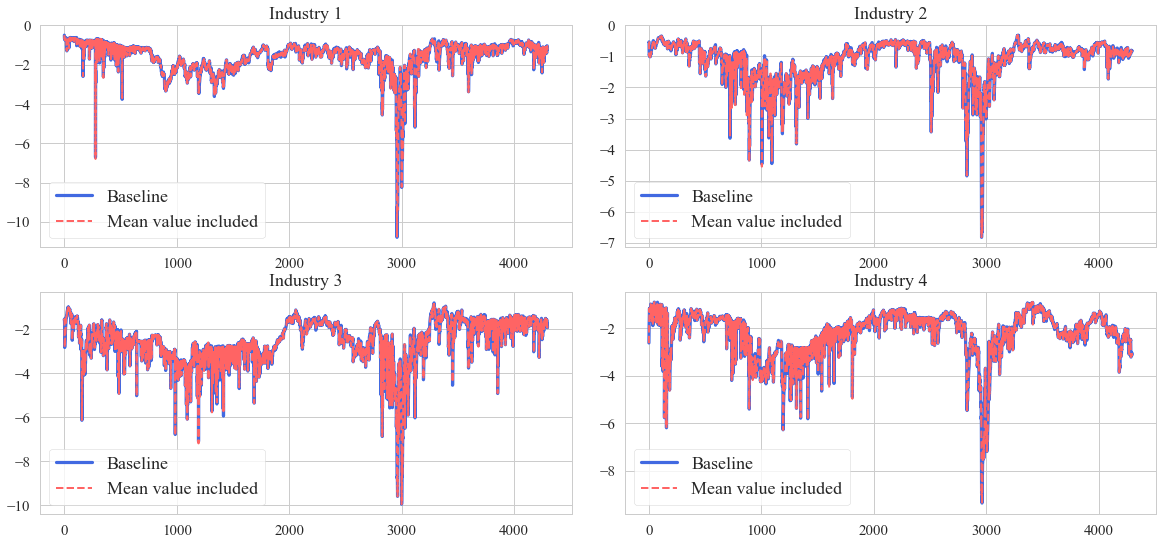

In [162]:
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.figure(figsize = (20, 9))
plt.subplots_adjust(wspace=0.1)
for i_ in range(1, 5):
    
    plt.subplot(2, 2, i_)
    
    plt.plot(result_5['VaR_5_{}'.format(i_)],
             color='royalblue', 
             lw=3.2,
             #linestyle='dashed',
             label='Baseline'
            )
    plt.plot(result_5_['VaR_5_{}'.format(i_)],
             color="#FF6464", 
             lw=2,
             linestyle='dashed',
             label='Mean value included')
    plt.legend(fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Industry {}'.format(i_), fontsize=18)
plt.show()

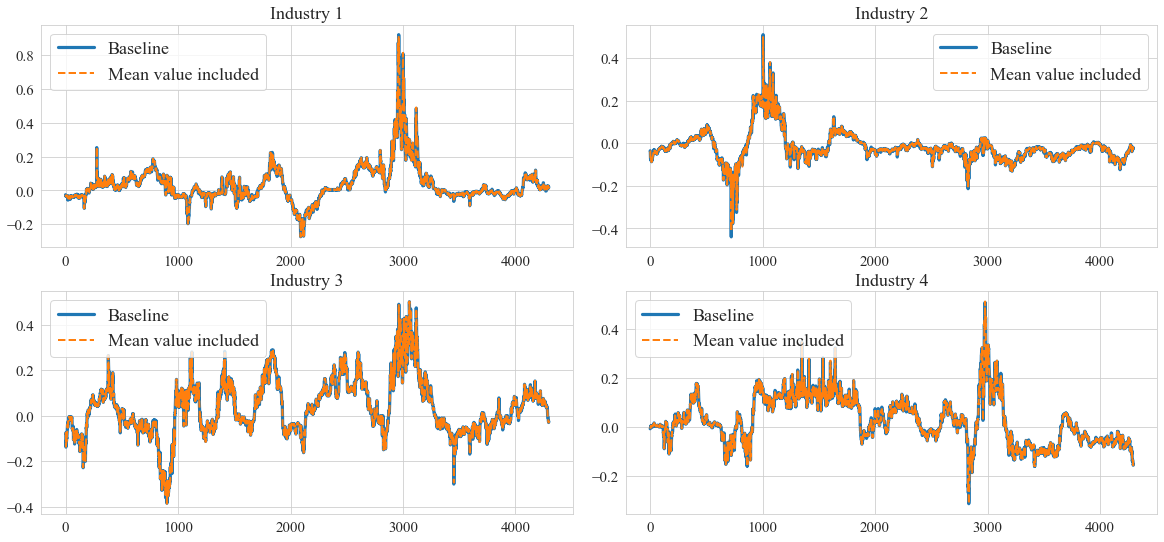

In [78]:
plt.figure(figsize = (20, 9))
plt.subplots_adjust(wspace=0.1)
for i_ in range(1, 5):
    
    plt.subplot(2, 2, i_)
    
    plt.plot(result_50['VaR_50_{}'.format(i_)],
             #color='royalblue', 
             lw=3.2,
             #linestyle='dashed',
             label='Baseline'
            )
    plt.plot(result_50_['VaR_50_{}'.format(i_)],
             #color="#FF6464", 
             lw=2,
             linestyle='dashed',
             label='Mean value included')
    plt.legend(fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Industry {}'.format(i_), fontsize=18)
plt.show()

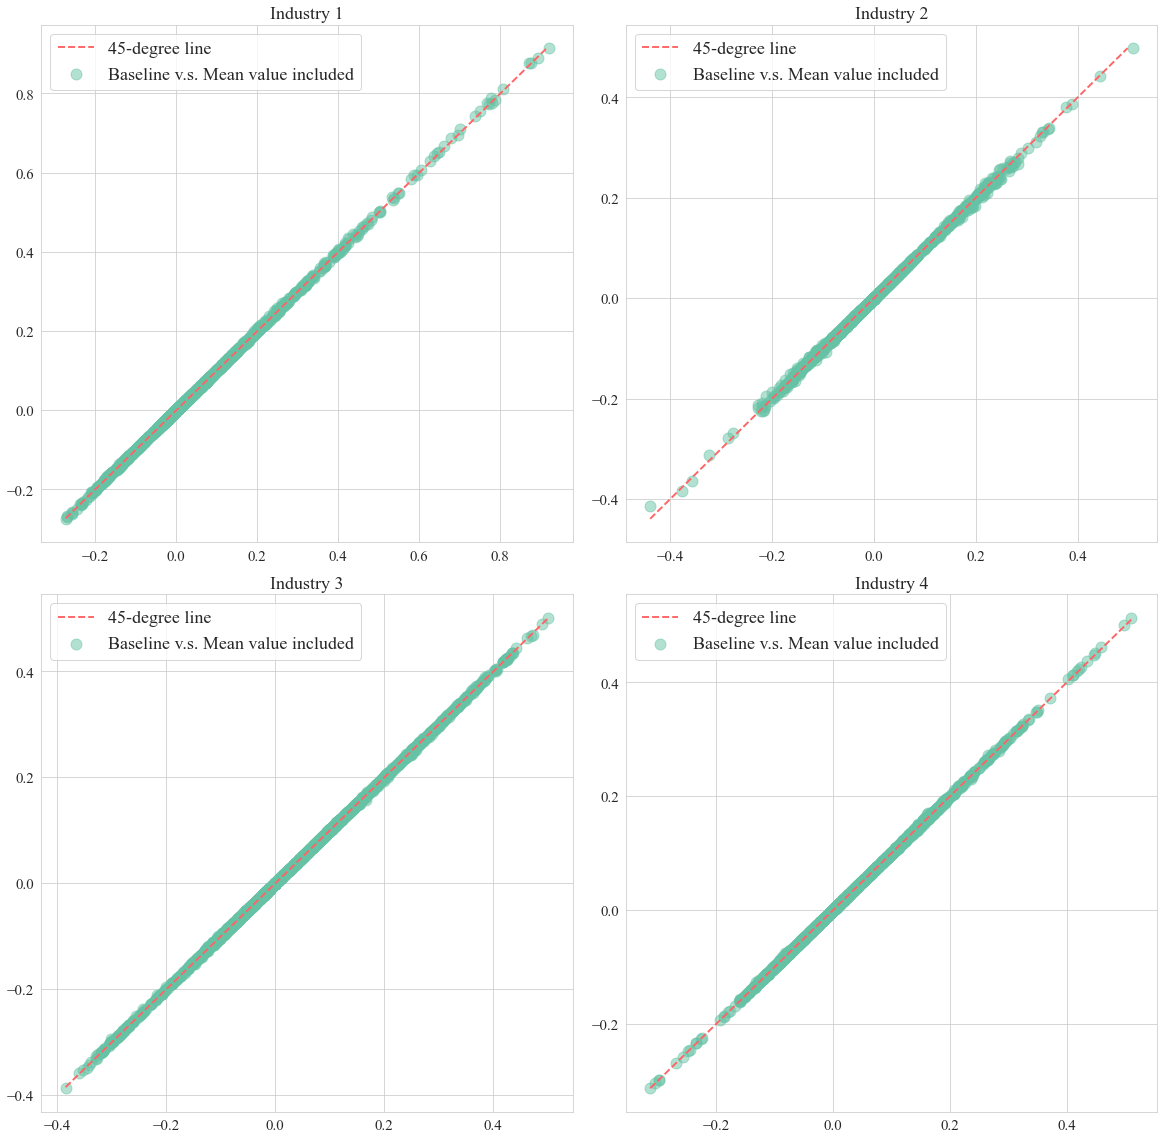

In [86]:
plt.figure(figsize = (20, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i_ in range(1, 5):
    
    plt.subplot(2, 2, i_)
    
    plt.scatter(result_50['VaR_50_{}'.format(i_)], 
                result_50_['VaR_50_{}'.format(i_)],
                color='#66C2A5', 
                alpha=0.5, 
                s=120)
    plt.plot([result_50['VaR_50_{}'.format(i_)].min(), result_50_['VaR_50_{}'.format(i_)].max()],
             [result_50['VaR_50_{}'.format(i_)].min(), result_50_['VaR_50_{}'.format(i_)].max()], 
             color="#FF6464", 
             linestyle='--',
             lw=1.9)

    plt.legend(["45-degree line", "Baseline v.s. Mean value included"], fontsize=18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Industry {}'.format(i_), fontsize=18)
plt.show()

In [ ]:
%%time
j = 1
for winsize in [125, 150, 175, 200, 225, 250]:
    len_of_s = 2 * winsize - 1
    print('OKOKOK')
    df = df_total[['date', 'R_1']]  # df is just a temp DataFrame
    df['VaR_5_' + str(j)] = np.nan
    df['VaR_50_' + str(j)] = np.nan
    print('OKOKOK')
    for k in range(df.shape[0] - len_of_s + 1):  # the 2rd loop --> time series level
        s = df['R_1'][k:k + len_of_s]
        VaR_5, VaR_50 = GARCH_HS(s, winsize)
        df.loc[k + len_of_s - 1, 'VaR_5_' + str(j)] = VaR_5
        df.loc[k + len_of_s - 1, 'VaR_50_' + str(j)] = VaR_50

    df = df.dropna()
    if j == 1:
        result_5__ = df[['date', 'VaR_5_' + str(j)]]
        result_50__ = df[['date', 'VaR_50_' + str(j)]]
    else:
        result_5__ = pd.merge(result_5__, df[['date', 'VaR_5_' + str(j)]], how='outer', 
                              on='date')
        result_50__ = pd.merge(result_50__, df[['date', 'VaR_50_' + str(j)]], how='outer',
                               on='date')
    j += 1

In [101]:
result_5__['date'] = pd.to_datetime(result_5__['date'], format="%Y-%m")

In [103]:
result_5__.set_index(keys='date')

,VaR_5_1,VaR_5_2,VaR_5_3,VaR_5_4,VaR_5_5,VaR_5_6
date,,,,,,
2002-04-17,-0.491675,NaN,NaN,NaN,NaN,NaN
2002-04-18,-0.538144,NaN,NaN,NaN,NaN,NaN
2002-04-19,-0.517019,NaN,NaN,NaN,NaN,NaN
2002-04-22,-0.526471,NaN,NaN,NaN,NaN,NaN
2002-04-23,-0.487594,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-25,-1.257283,-1.204958,-1.224693,-1.155384,-1.140152,-1.088117
2020-12-28,-1.248357,-1.183221,-1.191501,-1.121358,-1.102104,-1.053999
2020-12-29,-1.245238,-1.160147,-1.163204,-1.090740,-1.073687,-1.036799


In [106]:
winsize_ls = [125, 150, 175, 200, 225, 250]

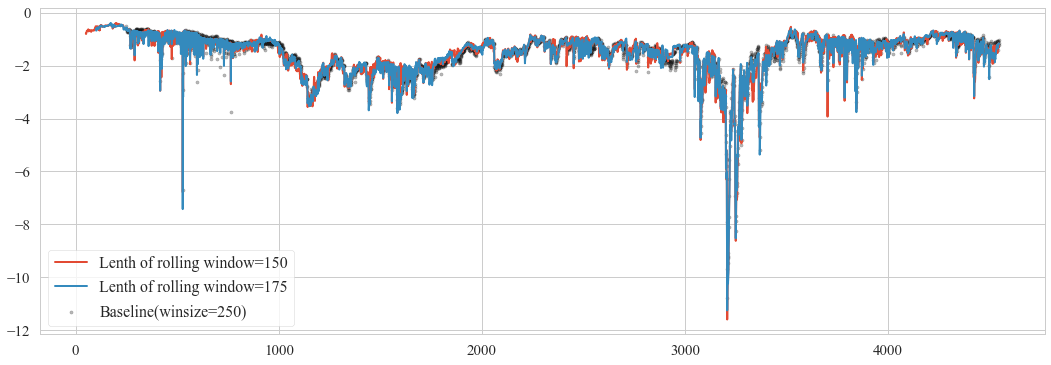

In [172]:
plt.figure(figsize = (18, 6))
for i_ in range(2, 4):
    plt.plot(result_5__['VaR_5_{}'.format(i_)],
             #color='royalblue', 
             lw=2,
             #linestyle='dashed',
             label='Lenth of rolling window={}'.format(winsize_ls[i_ - 1])
            )
plt.scatter(y=result_5__['VaR_5_{}'.format(6)], 
           x=np.arange(result_5__.shape[0]), 
           color='k',
           s=10, 
           marker='o', 
           alpha=0.3, 
           label='Baseline(winsize=250)')
plt.legend(fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('Rolling VaR at different winsizes.png', dpi=500)
plt.show()

In [166]:
plt.style.use('ggplot')
#sns.set()
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = 'Times New Roman'

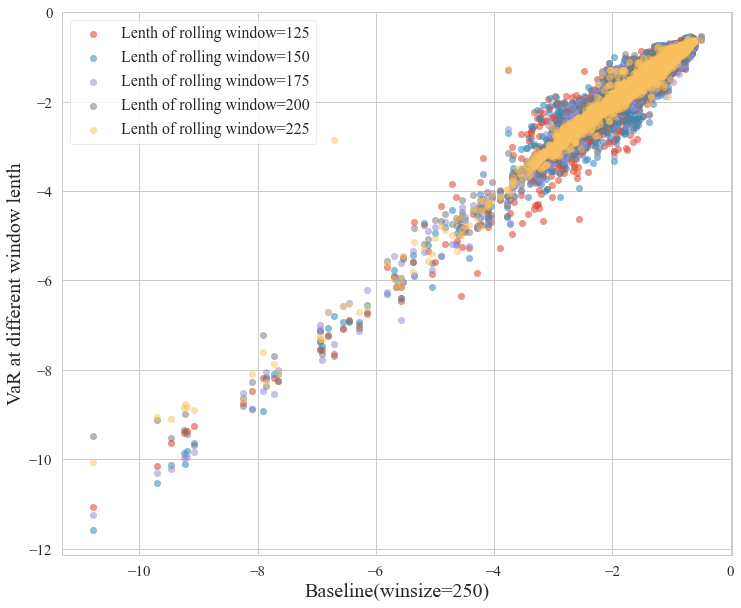

In [177]:
plt.figure(figsize = (12, 10))
for i_ in range(1, 6):

    plt.scatter(y=result_5__['VaR_5_{}'.format(i_)], 
               x=result_5__['VaR_5_{}'.format(6)], 
               #color='k',
               s=41, 
               #marker='x', 
               label='Lenth of rolling window={}'.format(winsize_ls[i_ - 1]), 
               alpha=(0.6 - 0.02 * i_))
'''plt.scatter(y=result_50__['VaR_50_{}'.format(6)], 
           x=result_5__['VaR_5_{}'.format(6)], 
           #color='k',
           s=41, 
           #marker='x', 
           label='Quantile=50%', 
           alpha=0.45)'''

plt.legend(fontsize=16, facecolor='white')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Baseline(winsize=250)', fontsize=20)
plt.ylabel('VaR at different window lenth', fontsize=20)
plt.show()

In [ ]:
%%time
for j in range(1, 2):  # the 1st loop --> Panel level

    df = df_total[['date', 'R_' + str(j)]]  # df is just a temp DataFrame
    df['VaR_5' + str(j)] = np.nan
    df['VaR_1' + str(j)] = np.nan

    for k in range(df.shape[0] - len_of_s + 1):  # the 2rd loop --> time series level
        s = df['R_' + str(j)][k:k + len_of_s]
        VaR_5, VaR_1 = GARCH_HS(s, winsize)
        df.loc[k + len_of_s - 1, 'VaR_5' + str(j)] = VaR_5
        df.loc[k + len_of_s - 1, 'VaR_1' + str(j)] = VaR_1

    df = df.dropna()
    if j == 1:
        res_5 = df[['date', 'VaR_5' + str(j)]]
        res_1 = df[['date', 'VaR_1' + str(j)]]
    else:
        res_5 = pd.merge(res_5, df[['date', 'VaR_5' + str(j)]], how='outer')
        res_1 = pd.merge(res_1, df[['date', 'VaR_1' + str(j)]], how='outer')

    print("》》》》》》{}!!".format(j))

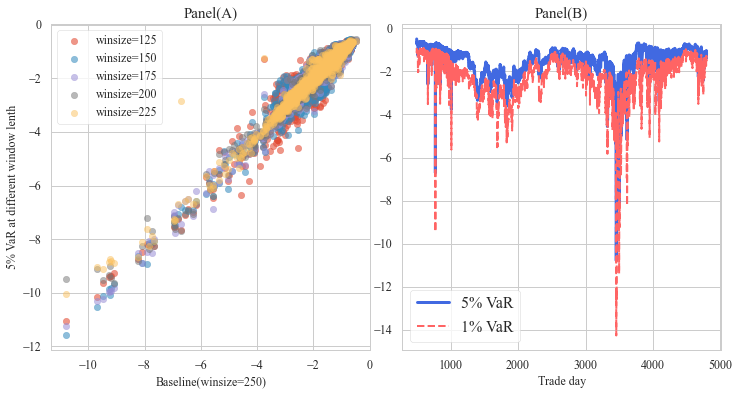

In [198]:
plt.figure(figsize = (12, 6))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1, 2, 1)
for i_ in range(1, 6):

    plt.scatter(y=result_5__['VaR_5_{}'.format(i_)], 
               x=result_5__['VaR_5_{}'.format(6)], 
               #color='k',
               s=41, 
               #marker='x', 
               label='winsize={}'.format(winsize_ls[i_ - 1]), 
               alpha=(0.6 - 0.02 * i_))

plt.legend(fontsize=12, facecolor='white')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Baseline(winsize=250)', fontsize=12)
plt.ylabel('5% VaR at different window lenth', fontsize=12)
plt.title('Panel(A)', fontsize=15)
plt.subplot(1, 2, 2)
plt.plot(res_5['VaR_51'],
         color='royalblue', 
         lw=3,
         #linestyle='dashed',
         label='5% VaR'
        )
plt.plot(res_1['VaR_11'],
         color="#FF6464", 
         lw=2,
         linestyle='dashed',
         label='1% VaR')
plt.legend(fontsize=16, facecolor='white')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Panel(B)', fontsize=15)
plt.xlabel('Trade day', fontsize=12)
plt.savefig('Function of Main code.png', dpi=600)
plt.show()